In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

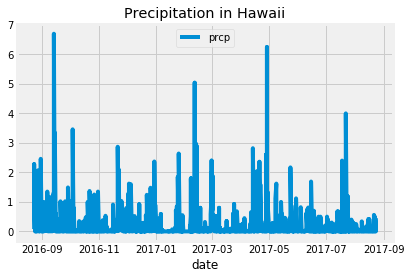

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
LastTwelve = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)
    
for date in LastTwelve:
    RecentDate = date.date

RecentDate = dt.datetime.strptime(RecentDate, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
OneYear = RecentDate - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
PrecipData = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= OneYear).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(PrecipData).dropna()

# Sort the dataframe by date
df['date'] = pd.to_datetime(df['date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df['date'], df['prcp'])
plt.title("Precipitation in Hawaii")
plt.xlabel('date')
plt.legend(loc=9)

![precipitation](Images/precipitation.png)

In [45]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [50]:
# Design a query to show how many stations are available in this dataset?
NumStations = session.query(Measurement.station).distinct().count()
NumStations

9

In [51]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
MostActive = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
MostActive

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [58]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
MostActiveSation = 'USC00519281'
LowHighAvg = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == MostActiveSation).all()
LowHighAvg

[(54.0, 85.0, 71.66378066378067)]

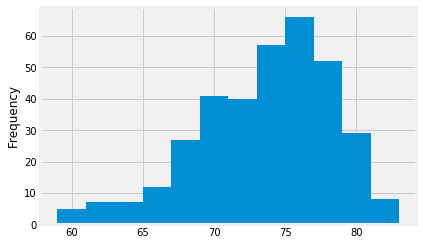

In [64]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
MostActiveQuery = session.query(Measurement.tobs).\
                                filter(Measurement.station==MostActiveSation).\
                                filter(Measurement.date >= OneYear).\
                                order_by(Measurement.date.desc()).all()

x = [x[0] for x in MostActiveQuery]


plt.hist(x, bins=12)
plt.ylabel('Frequency')
plt.show()

![precipitation](Images/station-histogram.png)

In [65]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [80]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
VacationTemps = calc_temps('2013-03-28', '2013-04-05')
VacationTemps

[(53.0, 67.56716417910448, 75.0)]

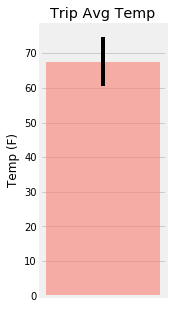

In [86]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

lower = VacationTemps[0][1] - VacationTemps[0][0]
upper = VacationTemps[0][2] - VacationTemps[0][1]

plt.figure(figsize=(2,5))
plt.bar(0, VacationTemps[0][1], yerr=[upper-lower], color='salmon', alpha=0.6)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')

plt.show()

In [98]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
TotalRain = session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                               Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 1, 1)).group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

TotalRainDf = pd.DataFrame(TotalRain, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Total Precipitation (in.)'])

TotalRainDf

,Station,Name,Latitude,Longitude,Elevation,Total Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,231.66
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,123.55
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,86.77
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,58.09
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,49.09
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,26.81
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,6.36


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


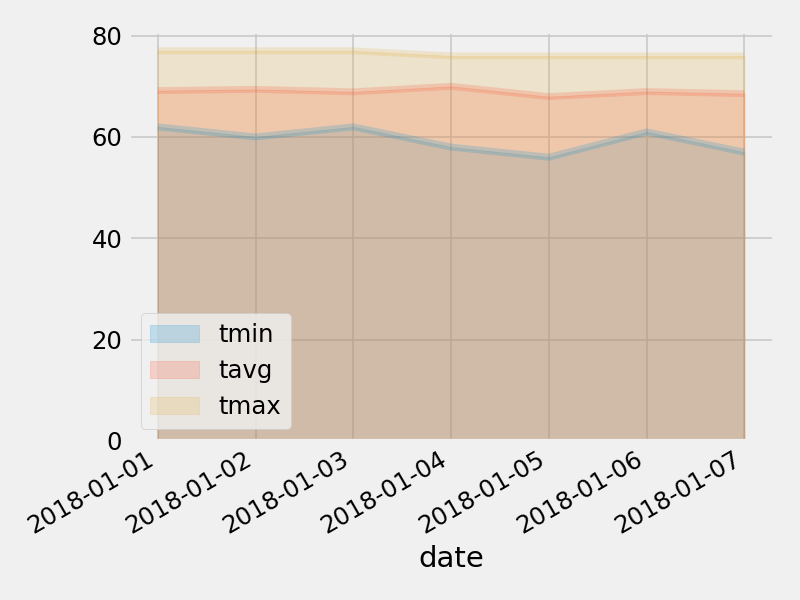

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
